# Task in this notebook

**List of tasks**
* EDA (Some EDA)
* Image PreProcessing (like augmentation)
* Divided dataset into
* * Train Dataset
* * Validation Dataset
* Basic Modeling Without Pre-Trained and check Loss curve
* Add pre_trained Model and check loss curve
* Some Tuning (if possible)

# 1. Setting basic configurations

In [1]:
from IPython.display import clear_output
!pip install -qU scikit-learn
!pip install -qU wandb
clear_output()

In [2]:
#Basick python libraries
%config Completer.use_jedi = False
import os, re, math, random, shutil, warnings, gc
import glob
import numpy as np, pandas as pd
from IPython import display as ipd
from glob import glob
from tqdm import tqdm

#Classical Ml tools
import sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#OpenCV Library
import cv2

#Plotting tools 
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Tensorflow and keras tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.python.client import device_lib

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

#Logging tools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid too many logging messages
pd.options.mode.chained_assignment = None
tf.get_logger().setLevel('ERROR')
py.init_notebook_mode(connected=True)


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [1]:

import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token.\
    Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token.    Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [3]:
devices = ['TPU', 'GPU']
img_size = [(1024,512), (512,256)]
img_ext = ['png']
#(512,256)

class Config:
    
    def __init__(self):
        self.wandb = True
        self.competition   = 'rsna-bcd' 
        self._wandb_kernel = 'awsaf49'
        self.debug        = False
        self.comment = 'EfficientNetV1B4-1024x512-roi-up=10-lr4-focal-vflip-wb'
        self.exp_name = 'roi-v2-fix' # name of the experiment, folds will be grouped using 'exp_name'
        # use verbose=0 for silent, vebose=1 for interactive,
        self.verbose = 1
        self.display_plot = True
        
        self.model_name = 'EfficientNetV1B4'
        
        # number of folds for data-split
        self.folds = 5
        
       # which folds to train
        self.selected_folds = [0, 1, 2]
        
        
        self.project_name="RSNA_BCD_Modeling"
        self.device=devices[0]
        self.seed=150
        
        self.path='/kaggle/input/rsna-bcs-imagepreprosessing/'
        self.training_imgs= self.path+'train_images'
        
        self.training_images_path='/kaggle/working/Training_Images/'
        self.validations_images_path='/kaggle/working/Validation_Images/'
        self.cancerous='Cancerous/'
        self.non_cancerous='Non_cancerous/'
        self.train_csv=self.path+'TrainDataset.csv'
        self.img_size = img_size[1]
        self.img_ext = img_ext[0]
        self.batch_size = 28
        
        self.epochs = 10
        
        # up sample
        self. upsample = 10
        
        # optimizer
        self.optimizer = 'Adam'
        
        # augmentation
        self.augment   = True
        

config=Config()
        

# 2. Seeding Random Generators for reproducibility

In [4]:
def seeding(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    print("Seeding done")
    
seeding(config.seed)

# 3.Configur devices
* device="TPU" for remote-tpu , device="GPU" for GPU

In [5]:
if config.device == 'TPU':
    
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        config.device = "GPU"

if config.device == "GPU"  or config.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
        
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        config.device = "CPU"
if config.device == "GPU":
    print("Num GPUs Available: ", ngpu)

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# GCS Path for TPU
* Remote-TPU requires GCS path. Kaggle Provides that for us 

In [ ]:
if config.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(self.path.split('/')[-1])

In [ ]:
# use gcs_path for remote-tpu
if config.device=="TPU":
    config.path = GCS_PATH

In [5]:
train_df = pd.read_csv(config.train_csv)
train_df.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,input_image_path,output_image_path
0,0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/462822612.png
1,1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1459541791.png
2,2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1864590858.png
3,3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1874946579.png
4,4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10011/220375232.png


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               54706 non-null  int64  
 1   site_id                  54706 non-null  int64  
 2   patient_id               54706 non-null  int64  
 3   image_id                 54706 non-null  int64  
 4   laterality               54706 non-null  object 
 5   view                     54706 non-null  object 
 6   age                      54669 non-null  float64
 7   cancer                   54706 non-null  int64  
 8   biopsy                   54706 non-null  int64  
 9   invasive                 54706 non-null  int64  
 10  BIRADS                   26286 non-null  float64
 11  implant                  54706 non-null  int64  
 12  density                  29470 non-null  object 
 13  machine_id               54706 non-null  int64  
 14  difficult_negative_cas

# 3. Exploratory Data Analysis (EDA)

**Train-Test Ditribution**

In [ ]:
print('train_files:',train_df.shape[0])
print('test_files:',train_df.shape[0])

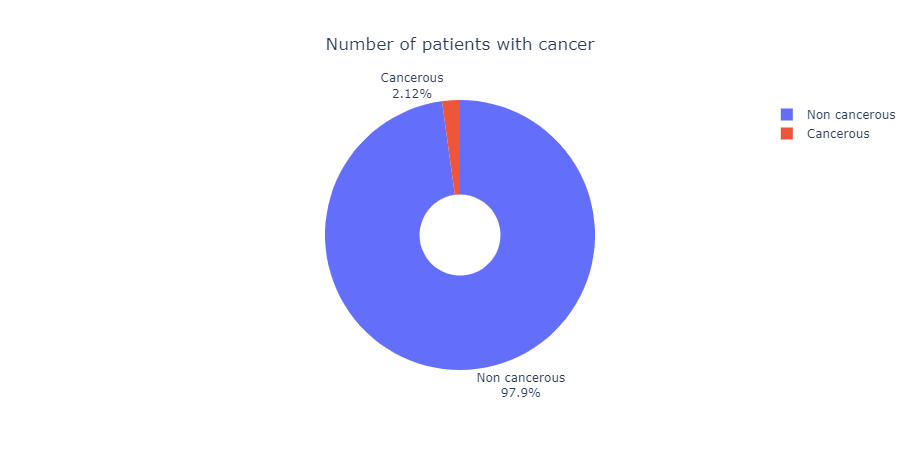

In [7]:
fig = go.Figure(data=[go.Pie(labels=['Non cancerous', 'Cancerous'], values=train_df['cancer'].value_counts(), hole=.3)])
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_text='Number of patients with cancer', title_x=0.5)
fig.show()


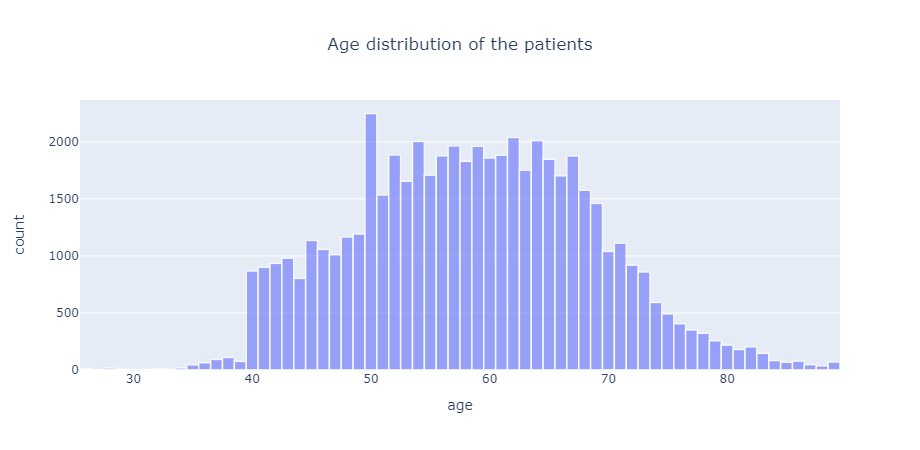

In [9]:
fig = px.histogram(train_df, x="age", title='Age distribution of the patients')
fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_x=0.5)
fig.show()

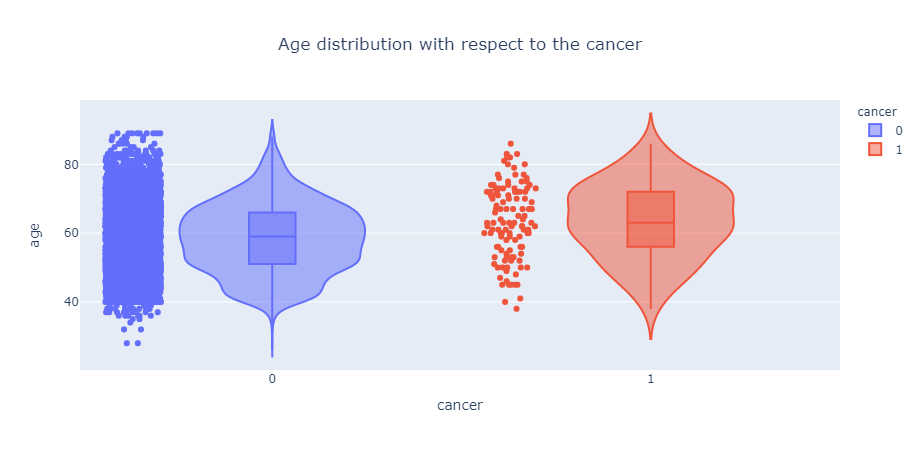

In [10]:

fig = px.violin(train_df.sample(frac=0.1), y="age", x="cancer", color="cancer", box=True, 
                points="all",
                title='Age distribution with respect to the cancer')
fig.update_layout(title_x=0.5)
fig.show()


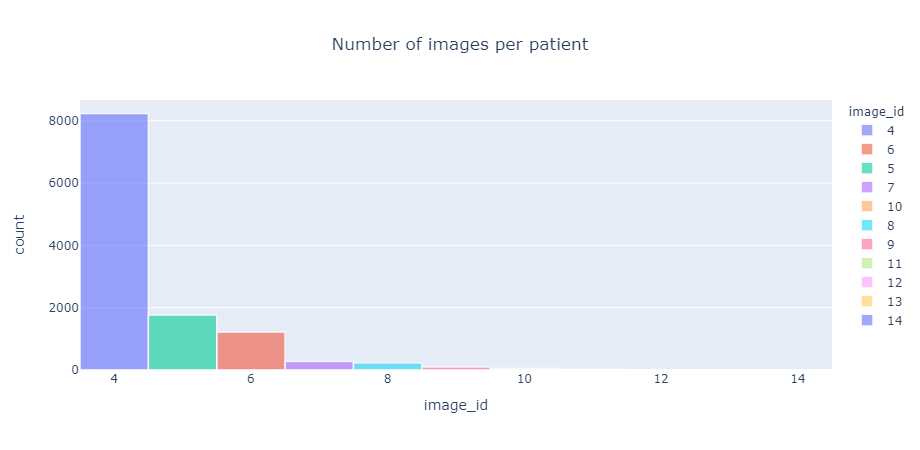

In [11]:
fig = px.histogram(train_df.groupby('patient_id').count().reset_index(), x="image_id", color='image_id',
                   title='Number of images per patient')
fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_x=0.5)
fig.show()

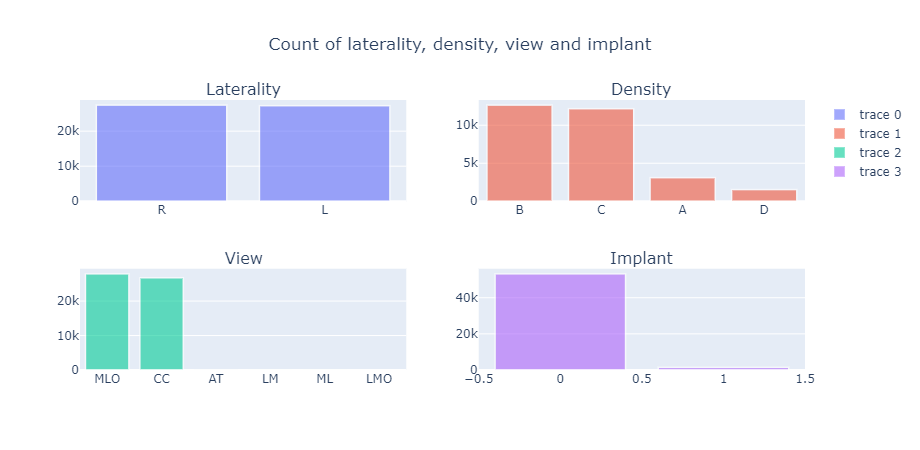

In [12]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Laterality', 'Density', 'View', 'Implant'))

fig.add_trace(go.Bar(x=train_df['laterality'].value_counts().index, y=train_df['laterality'].value_counts().values), row=1, col=1)
fig.add_trace(go.Bar(x=train_df['density'].value_counts().index, y=train_df['density'].value_counts().values), row=1, col=2)
fig.add_trace(go.Bar(x=train_df['view'].value_counts().index, y=train_df['view'].value_counts().values), row=2, col=1)
fig.add_trace(go.Bar(x=train_df['implant'].value_counts().index, y=train_df['implant'].value_counts().values), row=2, col=2)

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Count of laterality, density, view and implant', title_x=0.5)
fig.show()

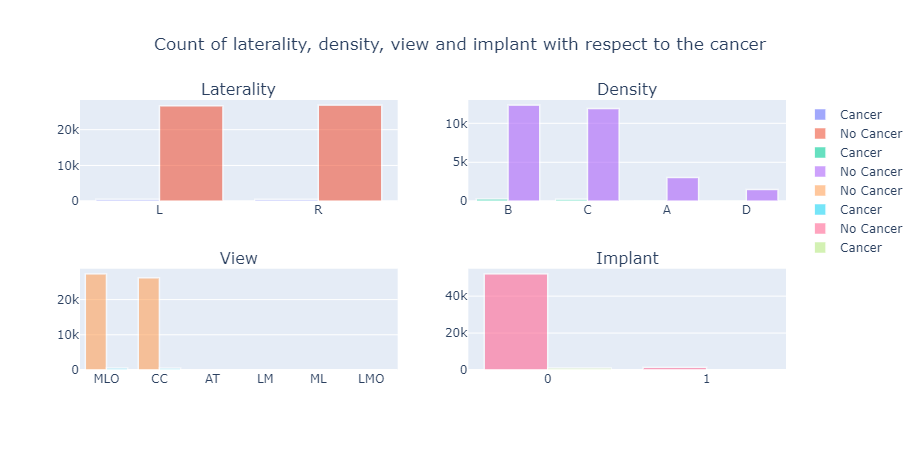

In [13]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Laterality', 'Density', 'View', 'Implant'))

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['laterality'].value_counts().index, y=train_df[train_df['cancer'] == 1]['laterality'].value_counts().values, name='Cancer'), row=1, col=1)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['laterality'].value_counts().index, y=train_df[train_df['cancer'] == 0]['laterality'].value_counts().values, name='No Cancer'), row=1, col=1)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['density'].value_counts().index, y=train_df[train_df['cancer'] == 1]['density'].value_counts().values, name='Cancer'), row=1, col=2)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['density'].value_counts().index, y=train_df[train_df['cancer'] == 0]['density'].value_counts().values, name='No Cancer'), row=1, col=2)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['view'].value_counts().index, y=train_df[train_df['cancer'] == 0]['view'].value_counts().values, name='No Cancer'), row=2, col=1)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['view'].value_counts().index, y=train_df[train_df['cancer'] == 1]['view'].value_counts().values, name='Cancer'), row=2, col=1)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['implant'].value_counts().index, y=train_df[train_df['cancer'] == 0]['implant'].value_counts().values, name='No Cancer'), row=2, col=2)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['implant'].value_counts().index, y=train_df[train_df['cancer'] == 1]['implant'].value_counts().values, name='Cancer'), row=2, col=2)

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Count of laterality, density, view and implant with respect to the cancer', title_x=0.5)
fig.show()

# 4. Missing Values 

In [14]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    return pd.concat([total,percentage] , axis = 1 , keys = ['Total' , 'Percent'])

missing_data(train_df)

,Total,Percent
BIRADS,28420,0.519504
density,25236,0.461302
age,37,0.000676
Unnamed: 0,0,0.000000
invasive,0,0.000000
input_image_path,0,0.000000
difficult_negative_case,0,0.000000
machine_id,0,0.000000
implant,0,0.000000
biopsy,0,0.000000


In [15]:
train_df = train_df.drop(['BIRADS'], axis=1)
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['density'] = train_df['density'].fillna('E')

In [16]:
missing_data(train_df)

,Total,Percent
Unnamed: 0,0,0.0
site_id,0,0.0
patient_id,0,0.0
image_id,0,0.0
laterality,0,0.0
view,0,0.0
age,0,0.0
cancer,0,0.0
biopsy,0,0.0
invasive,0,0.0


In [16]:
train_df['laterality'] = train_df['laterality'].astype('category')
train_df['view'] = train_df['view'].astype('category')
train_df['age'] = train_df['age'].astype('int64')
train_df['output_image_path'] = train_df['output_image_path'].astype('string')

# 5. Fix Data Types

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               54706 non-null  int64   
 1   site_id                  54706 non-null  int64   
 2   patient_id               54706 non-null  int64   
 3   image_id                 54706 non-null  int64   
 4   laterality               54706 non-null  category
 5   view                     54706 non-null  category
 6   age                      54706 non-null  int64   
 7   cancer                   54706 non-null  int64   
 8   biopsy                   54706 non-null  int64   
 9   invasive                 54706 non-null  int64   
 10  implant                  54706 non-null  int64   
 11  density                  54706 non-null  object  
 12  machine_id               54706 non-null  int64   
 13  difficult_negative_case  54706 non-null  bool    
 14  input_

# 6. Numerical Categorization

In [18]:
train_df["age_bin"] = pd.cut(train_df['age'].values.reshape(-1), bins=5, labels=False)

In [19]:
train_df.to_csv("TrainData.csv",sep=',')

# 7. Generate Dummy Variables 

In [20]:
cat_cols = ['laterality', 'view', 'density', 'difficult_negative_case']
train_df = pd.get_dummies(train_df, columns=cat_cols)

In [21]:
train_df.to_csv("TrainData.csv",sep=',')

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Unnamed: 0                     54706 non-null  int64 
 1   site_id                        54706 non-null  int64 
 2   patient_id                     54706 non-null  int64 
 3   image_id                       54706 non-null  int64 
 4   age                            54706 non-null  int64 
 5   cancer                         54706 non-null  int64 
 6   biopsy                         54706 non-null  int64 
 7   invasive                       54706 non-null  int64 
 8   implant                        54706 non-null  int64 
 9   machine_id                     54706 non-null  int64 
 10  input_image_path               54706 non-null  object
 11  output_image_path              54706 non-null  string
 12  age_bin                        54706 non-null  int64 
 13  l

# Data Preparation 

In [22]:
#if os.path.exists('/kaggle/working/Training_Images/Non_cancerous'):
    #os.remove('/kaggle/working/Training_Images/Non_cancerous')
   # print("File removed successfully")

In [23]:
# shutil.rmtree(config.training_images_path+config.non_cancerous)
# shutil.rmtree(config.training_images_path+config.cancerous)

# shutil.rmtree(config.validations_images_path+config.non_cancerous)
# shutil.rmtree(config.validations_images_path+config.cancerous)

In [8]:
# Create Training set directories for both classes
Training_cancer_dir = os.path.join(config.training_images_path, config.cancerous)
os.makedirs(os.path.dirname(Training_cancer_dir),exist_ok=True)

# Create the "No Cancer" directory
Training_no_cancer_dir = os.path.join(config.training_images_path,config.non_cancerous)
os.makedirs(os.path.dirname(Training_no_cancer_dir),exist_ok=True)

In [9]:
# Create Validations set directories for both classes
Validation_cancer_dir = os.path.join(config.validations_images_path, config.cancerous)
os.makedirs(os.path.dirname(Validation_cancer_dir),exist_ok=True)

# Create the "No Cancer" directory
Validations_no_cancer_dir = os.path.join(config.validations_images_path,config.non_cancerous)
os.makedirs(os.path.dirname(Validations_no_cancer_dir),exist_ok=True)

In [10]:
test_image_dirs = glob.glob(config.path+"test_images/*/*.png")
train_image_dirs = glob.glob(config.path+"train_images/*/*.png")

images_Cancer=[]
images_noCancer=[]

print(train_df.shape)

for image in train_image_dirs:
    imageId=str(image.split('/')[6].split('.')[0])
    cancer_status=str(train_df.loc[train_df["image_id"].astype(str)==imageId].iloc[0]["cancer"])
    
    if(cancer_status=='1'):
        images_Cancer.append(imageId)
    else:
        images_noCancer.append(imageId)

print("Number of training images with Cancer:",len(images_Cancer))
print("number of training images with no cancer:",len(images_noCancer))
print("total number of training images : ",len(train_image_dirs))
print("Data type of image no cancer :",type(images_noCancer))

(54706, 17)
Number of training images with Cancer: 1158
number of training images with no cancer: 7465
total number of training images :  8623
Data type of image no cancer : <class 'list'>


In [11]:
images_noCancer_=images_noCancer[:2000]
print(len(images_noCancer_))

2000


**Take 2000 images of non cancereous and all the cancereous images for model training**

In [12]:
datagen = ImageDataGenerator()

# Get the filenames and labels of the images in the source directory
data = datagen.flow_from_directory(
    directory=config.path,
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 8627 images belonging to 2 classes.


In [13]:
cancereous_images =[]
non_cancereous_images=[]
for i in range(len(data.filenames)):
    
    if str(data.filenames[i].split('/')[0])=='train_images':
        
        if str(data.filenames[i].split('/')[2].split('.')[0]) in images_noCancer_:
            img = cv2.imread(str(config.path)+data.filenames[i])
            img = cv2.resize(img, img_size[1][::-1], interpolation = cv2.INTER_AREA)
            non_cancereous_images.append(np.array(img))
           # plt.imshow(cancereous_images[0])
           #shutil.copy(os.path.join(config.path,data.filenames[i]), no_cancer_dir)
        elif str(data.filenames[i].split('/')[2].split('.')[0]) in images_Cancer:
            img = cv2.imread(str(config.path)+data.filenames[i])
            img = cv2.resize(img, img_size[1][::-1], interpolation = cv2.INTER_AREA)
            cancereous_images.append(np.array(img))
            #plt.imshow(cancereous_images[0])
            #shutil.copy(os.path.join(config.path,data.filenames[i]),cancer_dir)
        else:
            continue

In [15]:
print(len(cancereous_images))
print(len(non_cancereous_images))

1158
2000


**Find the class to be augmented**

In [16]:
# Select the images belonging to the class to augment
non_cancereous_images=np.array(non_cancereous_images)
cancereous_images = np.array(cancereous_images)

n_augment = len(non_cancereous_images)-len(cancereous_images)
idx_to_aug = np.random.randint(cancereous_images.shape[0], size=n_augment)
print("number of augumented images :",n_augment)

number of augumented images : 842


In [17]:
# split the data into training and validation sets
train_non_cancereous, val_non_cancereous = train_test_split(non_cancereous_images,
                                                            test_size=0.2, 
                                                            random_state=config.seed)

# create directories for the training and validation sets
for i, img in enumerate(train_non_cancereous):
    save_path = os.path.join(Training_no_cancer_dir, 'non_cancer_' + str(i) + '.png')
    cv2.imwrite(save_path, img)
    
for i, img in enumerate(val_non_cancereous):
    save_path = os.path.join(Validations_no_cancer_dir, 'non_cancer_' + str(i) + '.png')
    cv2.imwrite(save_path, img)

In [20]:
non_cancereous_images=[]
train_non_cancereous=[]
val_non_cancereous=[]

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

In [22]:
augumented_images = []

plt.figure(figsize=(10, 10))
for i in range(n_augment):
    augmented_image = data_augmentation(cancereous_images[idx_to_aug[i]])
    augumented_images.append(augmented_image)
    
    
#     if i<4:
#         ax = plt.subplot(2, 2, i + 1)
#         plt.imshow(augmented_image)
#         plt.axis("off")
#         #plt.imshow(cancereous_images[0])

<Figure size 1000x1000 with 0 Axes>

In [23]:
cancereous_images=np.append(cancereous_images, augumented_images,axis=0)

print("Number of cancereous images : ",len(cancereous_images))

Number of cancereous images :  2000


In [24]:
train_cancereous, val_cancereous = train_test_split(cancereous_images, 
                                                    test_size=0.2, 
                                                    random_state=config.seed)

# save the cancereous images into training and validation sets of their respective directories
for i, img in enumerate(train_cancereous):
    save_path = os.path.join(Training_cancer_dir, 'cancer_' + str(i) + '.png')
    cv2.imwrite(save_path, img)

for i, img in enumerate(val_cancereous):
    save_path = os.path.join(Validation_cancer_dir, 'cancer_' + str(i) + '.png')
    cv2.imwrite(save_path, img)
     
cancereous_images=[]
train_cancereous=[]
val_cancereous=[]

In [26]:
# set up data generator for resacaling the images
data_generator =ImageDataGenerator(rescale=1./255)

# load the training and validation data from directories and apply the data generator to rescale the images
train_dataset = image_dataset_from_directory(
    config.training_images_path,
    image_size=img_size[1],
    batch_size=config.batch_size,
    shuffle=True)

validation_dataset = image_dataset_from_directory(
    config.validations_images_path,
    image_size=img_size[1],
    batch_size=config.batch_size,
    shuffle=True)

Found 3200 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [39]:
#train_dataset = train_dataset.map(lambda x, y: (data_generator.flow(x, batch_size=config.batch_size, shuffle=False).next()[0].numpy(), y))


In [40]:
#validation_dataset=validation_dataset.map(lambda x, y: (data_generator.flow(x, batch_size=config.batch_size, shuffle=False).next()[0].numpy(), y))

In [41]:
#Displaying some randomly augmented training images
# import matplotlib.pyplot as plt
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#     break


In [26]:
# bcd_model = Sequential()
# bcd_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 256, 3)))
# bcd_model.add(MaxPooling2D((2, 2)))
# bcd_model.add(Conv2D(64, (3, 3), activation='relu'))
# bcd_model.add(MaxPooling2D((2, 2)))
# bcd_model.add(Conv2D(128, (3, 3), activation='relu'))
# bcd_model.add(MaxPooling2D((2, 2)))
# bcd_model.add(Conv2D(256, (3, 3), activation='relu'))
# bcd_model.add(MaxPooling2D((2, 2)))
# bcd_model.add(Flatten())
# bcd_model.add(Dense(512, activation='relu'))
# bcd_model.add(Dropout(0.5))
# bcd_model.add(Dense(1, activation='sigmoid'))

# bcd_model.summary()


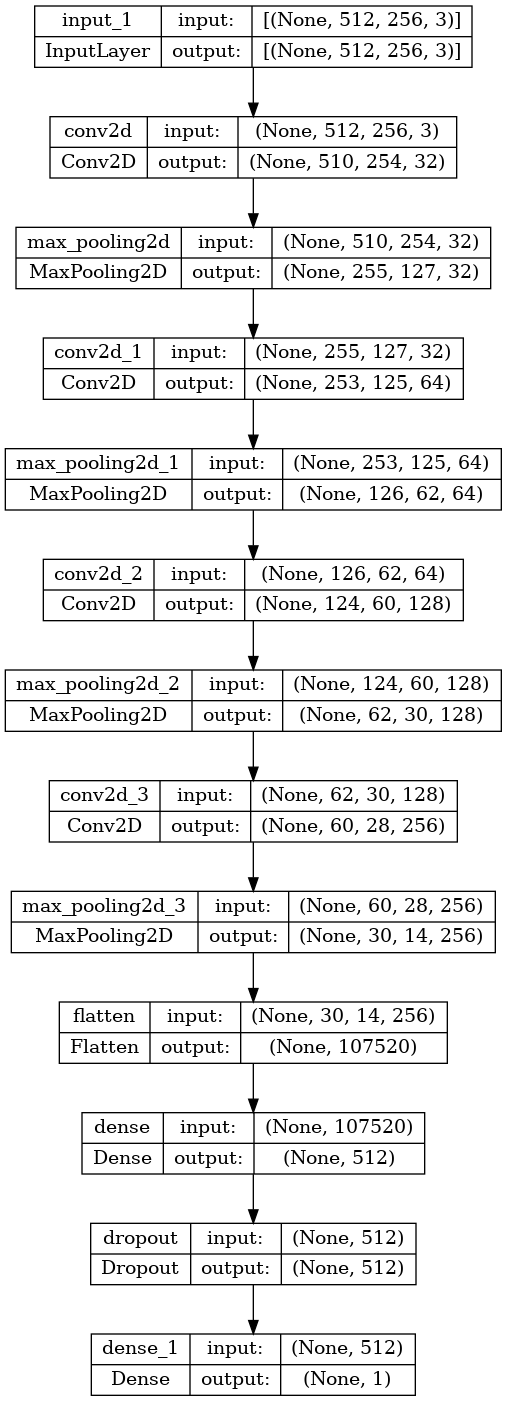

In [27]:
# Define input shape
input_shape = (512,256,3)
input_layer = Input(shape=input_shape)

# Define convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
maxpool3 = MaxPooling2D((2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu')(maxpool3)
maxpool4 = MaxPooling2D((2, 2))(conv4)

# Flatten and add fully connected layers
flatten = Flatten()(maxpool4)
dense1 = Dense(512, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout1)

# Define model and compile
bcd_model = Model(inputs=input_layer, outputs=output_layer)

plot_model(bcd_model,show_shapes=True)

In [28]:
bcd_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [29]:
images_Cancer=[]
images_noCancer=[]

In [ ]:
history = bcd_model.fit(
    train_dataset,
    epochs=10,
    batch_size=config.batch_size,
    validation_data=validation_dataset)

In [ ]:
# ###########################
# gender_model.save(save_model_path+'gender_model.h5')
# ###########################